In [101]:
from utils import *
from tensorflow.keras.models import Sequential, Model, Model, save_model
from tensorflow.keras.layers import LSTM, Embedding, Input, Dense, add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

### Loading data 

In [3]:
# Location of the Flickr8k images and caption files
dataset_image_path ="flickr8k/Images/"
dataset_text_path  ="flickr8k/captions.txt" 
# Wanted shape for images
wanted_shape = (224,224,3)

In [71]:
# To obtain the text dataset corresponding to images
train, infer = False, True

if train:
    df_texts = pd.read_csv(dataset_text_path, sep=",") #["image","caption"] 
elif infer:
    df_texts = pd.read_csv("df_texts.csv", index_col=0) # ["image","caption","cleaned","cleaned_tokenized"]
    print("df_texts loaded")
    print(df_texts.head())

n_img = df_texts.count()/5 # 40455/5 
unique_img = pd.unique(df_texts["image"])# 8091 unique images

df_texts loaded
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  \
0  A child in a pink dress is climbing up a set o...   
1              A girl going into a wooden building .   
2   A little girl climbing into a wooden playhouse .   
3  A little girl climbing the stairs to her playh...   
4  A little girl in a pink dress going into a woo...   

                                             cleaned  \
0  startseq child pink dress climbing set stairs ...   
1        startseq girl going wooden building  endseq   
2  startseq little girl climbing wooden playhouse...   
3  startseq little girl climbing stairs playhouse...   
4  startseq little girl pink dress going wooden c...   

                                   cleaned_tokenized  
0  ['startseq', 'child', 'pink', 'dress', 'climbi...  
1  ['st

### Preprocessing images with pretrained VGG16 : FEATURE MAPS 4096

In [5]:
base_model = VGG16(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=wanted_shape, pooling=None, classes=1000
)
# Feature extraction
vgg_model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output) #end the modèle with a 4096 feature layer

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [72]:
charge_image, one_by_one = False, False# false to gain time when testing other parts
# To obtain the feature maps
if train :
    if charge_image:
        feature_maps = np.array([vgg_model.predict(load_img_from_ds(unique_img[i])) for i in range(len(unique_img))])
        print(f"Shape des fm {feature_maps.shape}")
    elif one_by_one:
        feature_maps=[]
        for i in range(len(unique_img)):
            if i!=0:
                print(f"{i}/{len(unique_img)} - time elapsed :{time.time()-a}")
            else:
                print(f"{i}/{len(unique_img)}")
            a=time.time()
            img = load_img_from_ds(unique_img[i])
            feature_map = vgg_model.predict(img)
            feature_maps.append(feature_map)
        feature_maps=np.array(feature_maps)
        #save to csv
        feature_maps_sav=feature_maps[:,0,:]
        df_fm = pd.DataFrame(feature_maps_sav)
        df_fm.to_csv("image_feature_maps.csv")

elif infer:
    df_fm = pd.read_csv("image_feature_maps.csv")
    feature_maps = np.array(df_fm.drop([df_fm.columns[0]], axis=1))
    print(f"Image feature maps loaded : {feature_maps.shape}")

Image feature maps loaded : (8091, 4096)


### Preprocessing captions - WORD2VEC : EMBEDDINGS 4096

In [65]:
# Text preprocessing
df_texts["cleaned"]=[process_sentence(s) for s in df_texts["caption"]]
df_texts["cleaned_tokenized"]=[word_tokenize(w) for w in df_texts["cleaned"]]

In [66]:
nb_words = 8000
#dcaptions = df_text["caption"].iloc[keepindex].values
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(df_texts["cleaned_tokenized"])
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(df_texts["cleaned_tokenized"])
print(dtexts[:5])

vocabulary size : 8748
[[1, 26, 62, 134, 88, 343, 340, 5109, 631, 2], [1, 10, 266, 156, 86, 2], [1, 24, 10, 88, 156, 2344, 2], [1, 24, 10, 88, 340, 2344, 2], [1, 24, 10, 62, 134, 266, 156, 2903, 2]]


In [67]:
print(len(dtexts))

40455


### Preparing total model inputs

In [27]:
#if(len(feature_maps)==8091):
#    n_images_considered = 5#int(len(feature_maps)/9)
#    # Reduce memory consumption
#    feature_maps = feature_maps[:n_images_considered]
#    text_features= dtexts[:n_images_considered*5]

#print(f"Image feature maps : {feature_maps.shape}\nText features : {text_features.shape}")

In [73]:
dimages = feature_maps

In [29]:
def multiple_feature_maps(dimages):
    Ximage = []
    for image in dimages:
        for i in range (5):
            Ximage.append(image)
    Ximage=np.array(Ximage)
    return Ximage

In [78]:
dfeaturemaps = dimages
print(f"Images duplicated {dfeaturemaps.shape}")

Images duplicated (8091, 4096)


In [74]:
# Split dataset
def split_test_val_train(df, Ntest, Nval):
    return(df[:Ntest],
           df[Ntest:Ntest+Nval],
           df[Ntest+Nval:])
    """
    return(df[:1000],
           df[1000:20000],
           df[20000:21000])
    """

In [103]:
# Split du dataset
prop_test, prop_val = 0.2, 0.2
N = dfeaturemaps.shape[0]#len(df_texts["cleaned_tokenized"])
M = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)
Mtest, Mval = int(M*prop_test), int(M*prop_val)


Nimg = len(dimages)
# dt = true image caption cleaned
dt_test, dt_val, dt_train = split_test_val_train(dtexts, Mtest, Mval)
# di = true image array
di_test, di_val, di_train = split_test_val_train(dfeaturemaps, Ntest, Nval)
# fnm = image_name
fnm_test, fnm_val, fnm_train = split_test_val_train(df_texts["image"], Mtest, Mval)

In [95]:
print(f" Train: text {len(dt_train)}, image {di_train.shape}, fnm {fnm_train.shape}")
print(f" Test : text {len(dt_test)}, image {di_test.shape}, fnm {fnm_test.shape}")
print(f" Val  : text {len(dt_val)}, image {di_val.shape}, fnm {fnm_val.shape}")

 Train: text 24273, image (4855, 4096), fnm (37219,)
 Test : text 8091, image (1618, 4096), fnm (1618,)
 Val  : text 8091, image (1618, 4096), fnm (1618,)


In [96]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

22


In [97]:
def finalpreprocessing(dftext, dfimage, vocab_size, maxlen):
    print("# captions/images = {}".format(len(dftext)))
    
    Xtext, Ximage, ytext = [], [], []
    step = 0
    for text, image in zip(dftext, dfimage):
        step += 1
        for i in range(1, len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text], maxlen=maxlen).flatten()
            out_text = to_categorical(out_text, num_classes = vocab_size)
            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)
    print(f"Number of step/associated image and caption {step}")
    
    Xtext = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext = np.array(ytext)
    
    return(Xtext, Ximage, ytext, maxlen)

In [98]:
vocab_size = 8747#len(word2vec_model.wv.vocab)

Xtext_train, Ximage_train, ytext_train, maxlen = finalpreprocessing(dt_train, di_train, vocab_size, maxlen) 
Xtext_val, Ximage_val, ytext_val, _ = finalpreprocessing(dt_val, di_val, vocab_size, maxlen)

print(f"Vocab size {vocab_size}")
print(f"Training set : \n \tInput image : {Ximage_train.shape}\n\tInput text : {Xtext_train.shape}\n\tOutput text : {ytext_train.shape}")

# captions/images = 24273
Number of step/associated image and caption 4855
# captions/images = 8091
Number of step/associated image and caption 1618
Vocab size 8747
Training set : 
 	Input image : (34717, 4096)
	Input text : (34717, 22)
	Output text : (34717, 8747)


### RNN Model 

In [99]:
dim_embedding=64

# image input
input_img = Input(shape=(Ximage_train.shape[1],), name="InputImage")
input_img_2 = Dense(256,activation='relu',name="CompressedImageFeatures")(input_img)
# text input
input_txt = Input(shape=(maxlen,), name="InputSequence")
input_txt_2 = Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
input_txt_3 = LSTM(units=256, activation="relu", name="CaptionFeatures")(input_txt_2)

# Common part
common = add([input_txt_3, input_img_2])
common = Dense(256, activation='relu')(common)
common = Dense(vocab_size, activation='softmax')(common)

#Model
total_model  = Model(inputs=[input_img, input_txt],outputs=common)

total_model.compile(loss='categorical_crossentropy', optimizer='adam')
print(total_model.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputSequence (InputLayer)      [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 22, 64)       559808      InputSequence[0][0]              
__________________________________________________________________________________________________
InputImage (InputLayer)         [(None, 4096)]       0                                            
__________________________________________________________________________________________________
CaptionFeatures (LSTM)          (None, 256)          328704      embedding_6[0][0]                
____________________________________________________________________________________________

In [62]:
plot_model(total_model, to_file="model.png")

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### Model training 

In [102]:
hist = total_model.fit([Ximage_train, Xtext_train], ytext_train, epochs=5, verbose=1, batch_size=64, validation_data=([Ximage_val, Xtext_val], ytext_val))
total_model.save("model-2.h5")
save_model(total_model, "model.h5")

Train on 34717 samples, validate on 11897 samples
Epoch 1/5
34717/34717 [==============================] - 221s 6ms/sample - loss: 6.0889 - val_loss: 5.8020
Epoch 2/5
34717/34717 [==============================] - 219s 6ms/sample - loss: 5.4876 - val_loss: 5.7125
Epoch 3/5
34717/34717 [==============================] - 220s 6ms/sample - loss: 5.2264 - val_loss: 5.6834
Epoch 4/5
34717/34717 [==============================] - 227s 7ms/sample - loss: 5.0159 - val_loss: 5.6364
Epoch 5/5
34717/34717 [==============================] - 302s 9ms/sample - loss: 4.8199 - val_loss: 5.7189


### Model evaluation

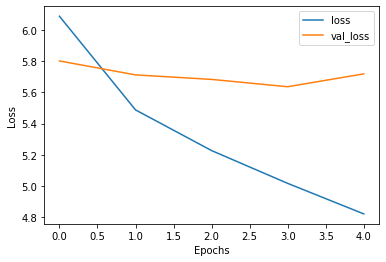

In [104]:
for label in ["loss", "val_loss"]:
    plt.plot(hist.history[label], label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

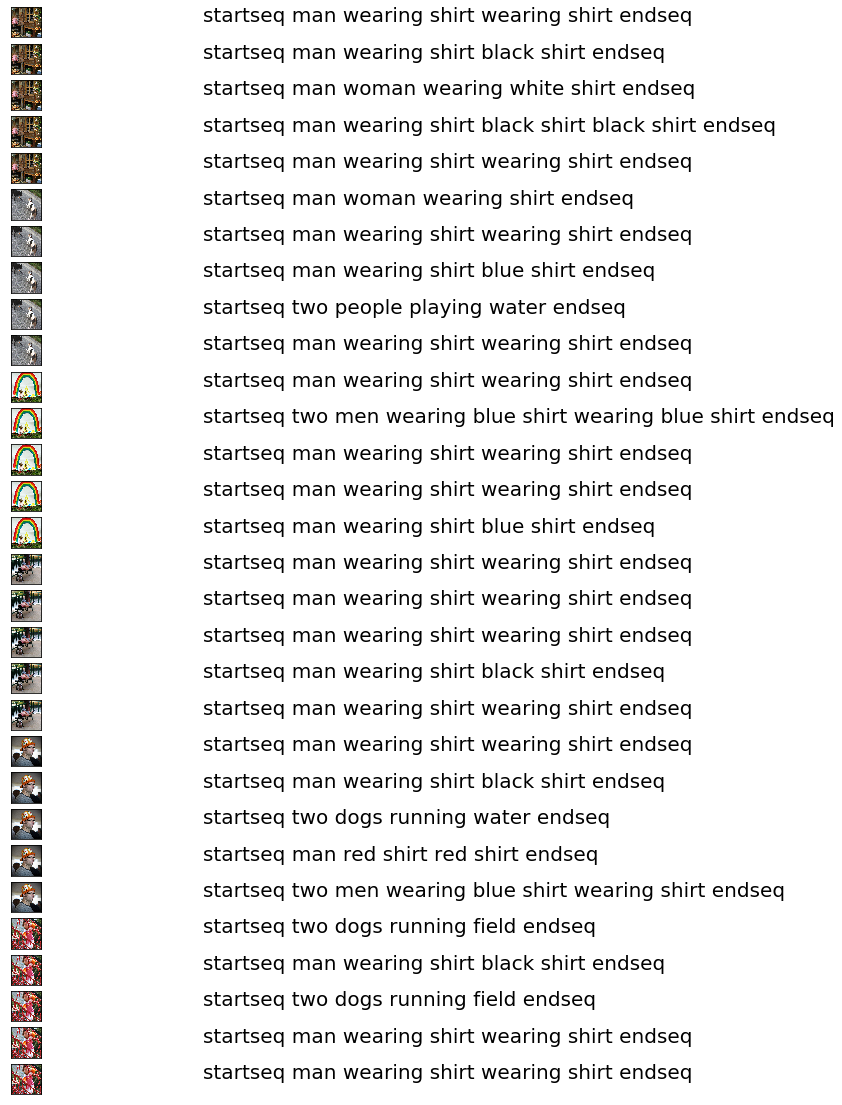

In [108]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = total_model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 30
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = dataset_image_path + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [ ]:
'''
PREDICTION
'''

# 1 couche 256 LSTM ?
# A partir de combien de couce=hes c est ok 1 8 16 32 256 
# Temps d entrainement : compromis 
# Voir si dimensions pas trop grandes ?
# GRU ! :D mieux (3 params au lieu de 4)
# simpleRNN ? 
# Etude comparative : 3 RNN (simple, LSTM, GRU & Etude de perf)
# Limiter Dataset ! => entrainements en O(heure)

#tf.keras.utils.get_file(origin="lien", fname="nom_que_tu_veux_donner_au_fichier.zip", extract=True)